# Draft

A jupyter notebook to test various small tasks. Each section can be run separately.

## Reading video from opencv

In [85]:
# importing opencv
import cv2

In [86]:
# testing reading video from opencv
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # capture frame
    ret, frame = cap.read()
    
    # display frame
    cv2.imshow("Testing camera", frame)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

## Mediapipe hand landmarks detection on still image

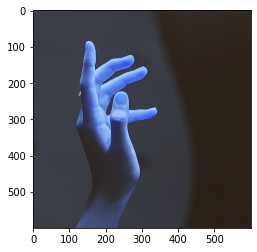

In [87]:
# Importing a test image
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/Hand_Model.jpg')
plt.imshow(img);

In [88]:
# Importing mediapipe modules
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [89]:
# creating a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='./models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

In [90]:
# loading input image
image = mp.Image.create_from_file("./data/Hand_Model.jpg")

In [91]:
# detect landmarks from image
detection_result = detector.detect(image)

In [92]:
#Implementing a function to visualize the hand landmark detection results (from mediapipe guide)

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

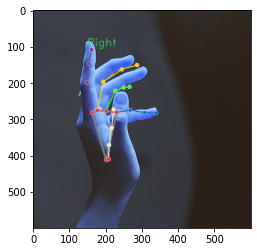

In [93]:
# Vizualize classification result
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Mediapipe hand landmarks detection on live video

Using detection + tracking

In [94]:
# importing opencv
import cv2

# importing mediapipe modules
import mediapipe as mp
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [95]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    if results.multi_hand_landmarks:
          for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

In [96]:
with mp_hands.Hands(max_num_hands = 2, min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # aiming for 25 fps
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()
        

## Saving landmarks

Hand detection + saving landmarks into a text file.

In [1]:
# importing opencv
import cv2

# importing numpy
import numpy as np

# importing mediapipe modules
import mediapipe as mp
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing_styles.get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    
def landmarks_to_array(results):
    out_array = np.concatenate(
            (np.array([(lm.x, lm.y, lm.z, lm.visibility) for lm in results.pose_landmarks.landmark[7:17]]
                if results.pose_landmarks
                    else np.zeros(40)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
                if results.left_hand_landmarks
                 else np.zeros(63)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]
                if results.right_hand_landmarks
                 else np.zeros(63)).flatten())
    )
    return(out_array)

In [41]:
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    n_frame = 1
    
    # setting up the np array 
    all_landmarks = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # wait 40 ms or break if 'q' is pressed
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
            
        # alternatively, break if we reach 75 frames
        #if n_frame > 75:
        #    break
        n_frame = n_frame + 1
    
        landmarks = landmarks_to_array(results)
        try:
            all_landmarks = np.vstack([all_landmarks, landmarks])
        except:
            all_landmarks = landmarks
        
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

np.save('all_landmarks.npy', all_landmarks)

In [46]:
loaded_all_landmarks = np.load('all_landmarks.npy')

In [47]:
loaded_all_landmarks

array([[ 0.63000405,  0.35943139, -0.61845803, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62988579,  0.35996452, -0.73263323, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62958002,  0.36115393, -0.74827659, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63185197,  0.38689554, -0.64050257, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63175112,  0.3868168 , -0.64150596, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63131285,  0.38667473, -0.63447016, ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
loaded_all_landmarks.shape

(47, 166)